### Importing required libraries

In [10]:
#Import all neccessary dependencies
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')
#Quality of image:
%config InlineBackend.figure_format = 'svg'

import praw
import pandas as pd
import regex as re
import numpy as np

from collections import Counter
from textblob import TextBlob


from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer


import string
import ast #using to convert string to python dict
import datetime

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, sent_tokenize

from textblob import TextBlob


### Loading the scraped data

In [11]:
dataDirectory = "./data/"
galaxy_df = pd.read_csv(dataDirectory + "galaxy.csv", encoding='utf-8')
iphone_df = pd.read_csv(dataDirectory + "iphone.csv", encoding='utf-8')

### Extracting posting time

In [12]:
# Step 1: converting string into python dictionary using ast library
galaxy_df["date"] = galaxy_df["data"].apply(lambda x: ast.literal_eval(x)['created_utc'])
iphone_df["date"] = iphone_df["data"].apply(lambda x: ast.literal_eval(x)['created_utc'])

# Step 1: converting string into python dictionary using ast library
galaxy_df["date"] = galaxy_df["date"].apply(datetime.date.fromtimestamp)
iphone_df["date"] = iphone_df["date"].apply(datetime.date.fromtimestamp)

galaxy_df["date"]

0       2021-10-29
1       2022-05-17
2       2022-05-17
3       2022-05-17
4       2022-05-17
           ...    
4891    2022-04-14
4892    2022-04-14
4893    2022-04-14
4894    2022-04-14
4895    2022-04-13
Name: date, Length: 4896, dtype: object

### Tagging the target feature

In [13]:
galaxy_df["is_iphone"]=0
iphone_df["is_iphone"]=1
iphone_df[:2]

,Unnamed: 0,kind,data,subreddit,title,name,selftext,domain,upvote_ratio,score,subreddit_id,is_robot_indexable,author,num_comments,send_replies,is_video,date,is_iphone
0,0,t3,"{'approved_at_utc': None, 'subreddit': 'iphone...",iphone,Weekly What Should I Buy Thread,t3_upgric,Welcome to the weekly stickied WSIB thread. \...,self.iphone,0.78,8,t5_2qh2b,True,AutoModerator,131,True,False,2022-05-14,1
1,1,t3,"{'approved_at_utc': None, 'subreddit': 'iphone...",iphone,Join The iPhone &amp; iOS Discord,t3_tyza7l,NaN,discord.gg,0.84,168,t5_2qh2b,True,SuitingUncle620,0,True,False,2022-04-08,1


### Merging the two dataframes

In [14]:
df = pd.concat([galaxy_df, iphone_df], ignore_index=True)
df.shape

(9666, 18)

In [15]:
df.drop(["Unnamed: 0", "subreddit", "subreddit_id"], axis=1, inplace=True)
print(df.shape)

(9666, 15)


In [16]:
if "data" in df.columns:
    df.drop(["data"], axis=1, inplace=True)
print(df.shape)

(9666, 14)


### Dropping the duplicated records

In [17]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(3977, 14)

In [18]:
pd.value_counts(df['is_iphone'], sort= True)

1    2740
0    1237
Name: is_iphone, dtype: int64

### Distribution of dataset

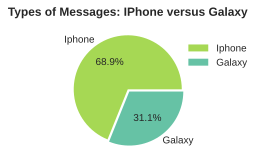

In [19]:
fig, ax = plt.subplots(figsize = (6,2.5))
lblComparison=pd.value_counts(df['is_iphone'], sort= True)
lblLst=["Iphone", "Galaxy"]



# only exploding the 2nd slice 
explode = (0, 0.05)

patches, texts, auto  = ax.pie(lblComparison, labels =lblLst, explode=explode, autopct='%1.1f%%')
n = len(patches)
for i in range(n):
    x = (n-1)/n - i/n
    patches[i].set_facecolor(plt.cm.Set2(x))

ax.set_title('Types of Messages: IPhone versus Galaxy', fontweight="bold")
ax.legend(loc="upper right", facecolor='linen', bbox_to_anchor=(1.45, 0.9))
ax.set_ylabel('');

In [20]:
def make_box_plot(df, cols):
    """
    This function will show box plot for the passed features.
    Input: df: a dataframe, 
           cols: a list of feature names for box plot.
    output: This function only show box plot.
    """
    cnt = len(cols)
    if cnt == 1:
        col = cols[0]
        fig, ax = plt.subplots(figsize=(5,3))
        sns.boxplot(x=df[col], ax=ax);
        #axes[i].set_title('Distribution')
        ax.set_xlabel(col)
    else:

        fig, axes = plt.subplots(cnt, 1, figsize=(5,3*cnt))

        for i, col in enumerate(cols):
            sns.boxplot(x=df[col], ax=axes[i]);
            #axes[i].set_title('Distribution')
            axes[i].set_xlabel(col)
            #axes[i].set_ylabel('Count');
        fig.tight_layout()
    return

def make_box_plot_comparison(df, cols, target):
    """
    This function will show box plot for the passed features.
    Input: df: a dataframe, 
           cols: a list of feature names for box plot.
    output: This function only show box plot.
    """
    cnt = len(cols)
    if cnt == 1:
        col = cols[0]
        fig, ax = plt.subplots(figsize=(5,3))
        sns.boxplot(x=df[col], ax=ax);
        #axes[i].set_title('Distribution')
        ax.set_xlabel(col)
    else:

        fig, axes = plt.subplots(cnt, 2, figsize=(10,3*cnt))

        for i, col in enumerate(cols):
            sns.boxplot(x=df.loc[df[target]==0, col], ax=axes[i, 0]);
            axes[i, 0].set_xlabel(col)
            axes[i, 0].set_title('{} for Samsung'.format(col))
            
            sns.boxplot(x=df.loc[df[target]==1, col], ax=axes[i, 1]);
            axes[i, 1].set_xlabel(col)
            axes[i, 1].set_title('{} for Iphone'.format(col))
            
            #axes[i].set_ylabel('Count');
        fig.tight_layout()
    return

### Numerical variables

In [21]:
numFeatures = ['upvote_ratio', 'score', 'num_comments']

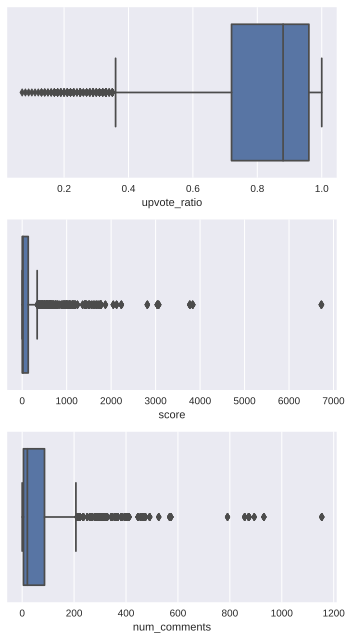

In [13]:
make_box_plot(df, numFeatures)

### Insights:
- For sure we have some extreme values for score and number of comments.
- Are they outliers?
- To answer this question, we need to focus on the concept of each variable. For example, it is realistic to have a number of comments about 1200. While this is not necessarily true for every numerical variables.
- For a better resolution of box plot let's focus on the majority of data.

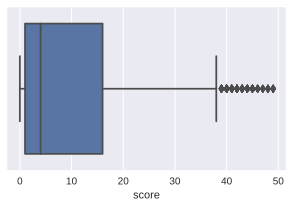

In [14]:
make_box_plot(df.loc[df["score"]<50], ["score"])

### Insight:
- It is clear that the score of the majority of our records are less than 10. However, the comparison between this plot and previous one, confirms that the score feature is a highly right skewed feature.

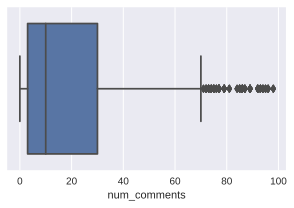

In [15]:
make_box_plot(df.loc[df["num_comments"]<100], ["num_comments"])

### Insight:
- It is clear that the number of comments for the majority of our records are less than 20. However, similar to the score feature, the number of comments is also a highly right skewed feature.

### Question: What is the distribution of numerical variables over target feature?

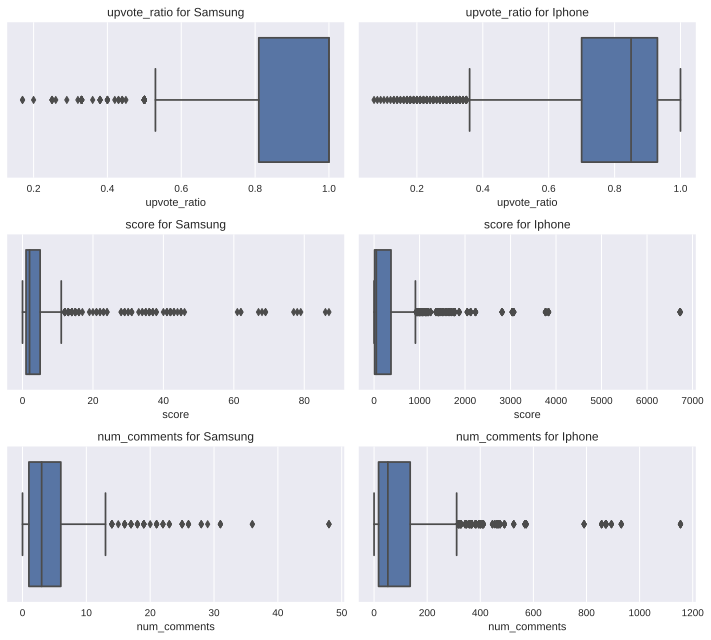

In [16]:
make_box_plot_comparison(df, numFeatures, "is_iphone")

### Insights:
- For the two variables of score and number of comments, there are very big difference between the records of galaxy versus iphone.
- One can easily conclude that each record with a score higher than 90 is labeld as iphone.
- Similarly for number of comments, all records with comments more than 50 should be iphone.
- Therefore, score and number of comments are two helpful features for the prediction purposes. 
- However, it should be considered that these plots are obtained by almost 10,000 records. One may see pretty different behavior for a different dataset.
- In addition, for a better conclusion, it is preferable to consider the user geolocation impact as well. For example, users in different countries may have different shopping habbit depending on their income, culture, free/close market, etc.

### Categorical and boolean variables

In [22]:
cols = ["kind", "is_robot_indexable", "send_replies", "is_video"]
for col in cols:
    print("##### {} #####".format(col))
    print(df[col].value_counts(normalize=True))
    print()

##### kind #####
t3    1.0
Name: kind, dtype: float64

##### is_robot_indexable #####
True    1.0
Name: is_robot_indexable, dtype: float64

##### send_replies #####
True     0.936133
False    0.063867
Name: send_replies, dtype: float64

##### is_video #####
False    0.983907
True     0.016093
Name: is_video, dtype: float64



### Insights:
- **kind:** the value of kind for all records are "t3". We can drop it, since it is not helpful for the prediction purposes.
- **is_robot_indexable:** the same behavior for robot indexing. Thus, we can drop it.
- **send_replies:** more than 93% of records are true.
- **is_video**: only 1.6% of posts are video which absolutely makes sense as Reddit is a text based platform.

In [23]:
print(df.shape)
df.drop(["kind", "is_robot_indexable"], axis=1, inplace=True)
print(df.shape)

(3977, 14)
(3977, 12)


In [19]:
df[:2]

,title,name,selftext,domain,upvote_ratio,score,author,num_comments,send_replies,is_video,date,is_iphone
0,Samsung Galaxy Tab S6 Lite Short Review,t3_qi6fn3,NaN,altechelectronics.org,1.0,12,AL0411,5,True,False,2021-10-29,0
1,The best I can do with macro on the s22 Ultra....,t3_us1mdv,NaN,reddit.com,1.0,2,ArachWitch,1,True,False,2022-05-17,0


### Question: Is there any difference in distribution of send_replies and video existance?

In [24]:
def make_bar_plot (data, bartype="bar", xlabel=None, ylabel=None, title=None, rotation=0, size=(5,3), legend=False):

    fig, ax = plt.subplots(figsize=size)
    data.plot(kind=bartype, ax = ax)
    if title:
        ax.set_title(title)
    if ylabel:
        ax.set_ylabel(ylabel)
    if xlabel:
        ax.set_xlabel(xlabel)
        
    ax.tick_params(axis='x', labelrotation=rotation)

    if legend:
        ax.legend(loc="upper right", facecolor='linen', bbox_to_anchor=(1.25, 0.9))

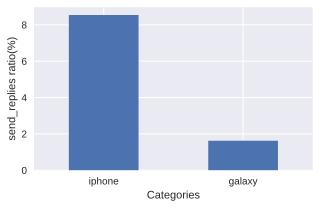

In [25]:
iphone_reply = df.loc[df["is_iphone"]==1, "send_replies"].value_counts(normalize=True)[0]
iphone_reply = round(iphone_reply*100, 2)

galaxy_reply = df.loc[df["is_iphone"]==0, "send_replies"].value_counts(normalize=True)[0]
galaxy_reply = round(galaxy_reply*100, 2)

serries_reply = pd.Series(data=[iphone_reply, galaxy_reply], index=["iphone", "galaxy"])

make_bar_plot(serries_reply, xlabel="Categories", ylabel="send_replies ratio(%)")

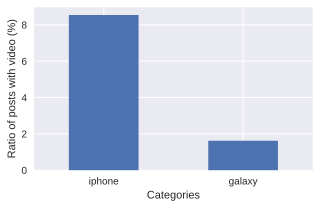

In [26]:
# Since the reddit posts of iphone do not have any video, we use 1-value_counts[0]
iphone_video = 1 - df.loc[df["is_iphone"]==1, "is_video"].value_counts(normalize=True)[0]
iphone_video = round(iphone_video*100, 2)

galaxy_video = 1 - df.loc[df["is_iphone"]==0, "is_video"].value_counts(normalize=True)[0]
galaxy_video = round(galaxy_video*100, 2)

serries_video = pd.Series(data=[iphone_video, galaxy_video], index=["iphone", "galaxy"])

make_bar_plot(serries_reply, xlabel="Categories", ylabel="Ratio of posts with video (%)")

### Insights:
- There is a contrast in the distribution of posts including videos and send_replies.
- More than 8% of iphone posts have send_replies against less than 3% for galaxy.
- None of iphone posts have video, while more than 5% of galaxy posts have video; Does it mean that galaxy owners use the cell's camera more? (hope we can explore)


In [27]:
df["domain"].value_counts()[:2]

self.iphone           2078
self.samsunggalaxy     880
Name: domain, dtype: int64

In [28]:
# How many ratio of records can easily be distinguished by domain features?
extracted_by_two_classes = df["domain"].value_counts()[:2].sum()
total = df.shape[0]
ratio = np.round(extracted_by_two_classes*100/total, 2)
print("{:0.2f}% of records can easily be classified by domain features.".format(ratio))

74.38% of records can easily be classified by domain features.


### Insights:
- Only two subclasses of "domain" feature are able to detect the subreddit by ~80%
- In order to make the prediction more complex, we will drop the features.
- For simplification purposes, we will also drop name and author.

In [29]:
df.drop(["domain", "name", "author"], axis=1, inplace=True)
df.shape

(3977, 9)

In [26]:
df[:2]

,title,selftext,upvote_ratio,score,num_comments,send_replies,is_video,date,is_iphone
0,Samsung Galaxy Tab S6 Lite Short Review,NaN,1.0,12,5,True,False,2021-10-29,0
1,The best I can do with macro on the s22 Ultra....,NaN,1.0,2,1,True,False,2022-05-17,0


In [30]:
df['selftext'].fillna('', inplace=True) 
df["main"] = df['title'] + " " + df['selftext']
df.drop(["title", "selftext"], axis=1, inplace=True)
df = df[["main", "date", "upvote_ratio", "score", "num_comments", "send_replies", "is_video", "is_iphone"]]
print(df.shape)
df[:2]

(3977, 8)


,main,date,upvote_ratio,score,num_comments,send_replies,is_video,is_iphone
0,Samsung Galaxy Tab S6 Lite Short Review,2021-10-29,1.0,12,5,True,False,0
1,The best I can do with macro on the s22 Ultra....,2022-05-17,1.0,2,1,True,False,0


In [31]:
def findToken(txt):
    """input: an string
    output: A list including word token of input text
    """
    return word_tokenize(txt)


def findWordCount(txt):
    """input: an string
    output: count of words appeared in the input string
    """
    return len(txt.split())

def findTokenCount(tokenLst):
    """input: a list of token
    output: count of words presented in list
    """
    return len(tokenLst)

def findAVGWordLen(tokenLst):
    """input: a list of token
    output: Average of word length in the input string
    """
    lengthLst = [len(x) for x in tokenLst]
    return np.mean(lengthLst)

def findNumericWord(tokenLst):
    """input: a list of token
    output: count of numerical word in the input string
    """
    numWordLst = [x for x in tokenLst if x.isdigit()]
    #numWordLst = map(lambda x:len(x), numWordLst)#[x for x in tokenLst if x.isdigit()]
    return len(numWordLst)

def findUpperWord(tokenLst):
    """input: a list of token
    output: count of uppercase word in the input string
    """
    upperWordLst = [x for x in tokenLst if x.isupper()]
    return len(upperWordLst)


def findStopWord(tokenLst):
    """input: a list of token
    output: count of stop word in the input string
    """
    stopWordLst = [x for x in tokenLst if x in stopwords.words('english')]
    return len(stopWordLst)


def checkIfStringPresented(text, str1):
    """input: a list of token
    output: check if a given string is presented in the input string
    """
    res = [1 if str1 in text else 0]
    return res[0]


def findCharacterCount(txt):
    """input: an string
    output: count of words appeared in the input string
    """
    return len(txt)


def findPunctuationCount(txt):
    """input: an string
    output: count of punctuations appeared in the input string
    """
    puncStr = string.punctuation
    puncResult = [char for char in txt if char in puncStr]
    return len(puncResult)

def textPreprocess(txtLst):
    """input: a dataframe having text in message column
    output: the same datframe where:
            phone number, currency symbols, URL, and email addresses are replace with an alternative placeholder
    """
    processLst = [' ']*len(txtLst)
    for i, text in enumerate(txtLst):
        # Replacing currency symbols with '(cur_plh)'
        text = re.sub(r'\$|£|€', '(cur_plh)', text)

        # Replacing URLs with '(url_plh)'
        text = re.sub(r'http[^\s]+', '(url_plh)', text)

        # Replacing email addresses with '(eml_plh)'
        text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '(eml_plh)', text)
        processLst[i] = text
    return processLst

## Feature Engineering

In [32]:
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['main']), axis=1)

In [33]:
df.loc[:, 'processed_main'] = textPreprocess(df['main']);

In [34]:
df.loc[:, 'hasURL'] = [1 if '(url_plh)' in line else 0 for line in df.loc[:, 'processed_main']]

df.loc[:, 'hasEmail'] = [1 if '(eml_plh)' in line else 0 for line in df.loc[:, 'processed_main']]

In [35]:
df['token_count'] = df['token'].apply(findTokenCount)

df['avg_word_length'] = df['token'].apply(findAVGWordLen)

df['upper_count'] = df['token'].apply(findUpperWord)

df['stop_count'] = df['token'].apply(findStopWord)

df['numeric_count'] = df['token'].apply(findNumericWord)

df['hasNumber'] = np.where(df['numeric_count'] == 0, 0, 1)

In [33]:
df[:3]

,main,date,upvote_ratio,score,num_comments,send_replies,is_video,is_iphone,token,processed_main,hasURL,hasEmail,token_count,avg_word_length,upper_count,stop_count,numeric_count,hasNumber
0,Samsung Galaxy Tab S6 Lite Short Review,2021-10-29,1.0,12,5,True,False,0,"[Samsung, Galaxy, Tab, S6, Lite, Short, Review]",Samsung Galaxy Tab S6 Lite Short Review,0,0,7,4.714286,1,0,0,0
1,The best I can do with macro on the s22 Ultra....,2022-05-17,1.0,2,1,True,False,0,"[The, best, I, can, do, with, macro, on, the, ...",The best I can do with macro on the s22 Ultra....,0,0,18,3.500000,1,5,0,0
2,Clear case recommendations? I finally ordered ...,2022-05-17,1.0,2,0,True,False,0,"[Clear, case, recommendations, ?, I, finally, ...",Clear case recommendations? I finally ordered ...,1,0,358,4.779330,18,95,3,1


In [37]:
df['punc_count'] = df['main'].apply(findPunctuationCount)

In [38]:
def makeHist(df, col, title=None, x_range=None, bins='auto', x_tickLst = None):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    lblLst = ['iphone', 'galaxy']
        
    if (x_range != None):
        df = df.loc[(df[col] >= x_range[0]) & (df[col] <= x_range[1])]
    
    for label, ax in zip(lblLst, axes.flatten()):
        if(label == 'ham'):
            color = 'cornflowerblue'
        else:
            color='orangered'
        sns.histplot(df.loc[df['is_iphone'] == label, col], color = color, kde=False, cbar_kws=dict(edgecolor="k"), ax=ax, stat='probability', bins=bins);
        if(x_range!= None):
            ax.set(xlim=x_range)
        
        ax.set_xlabel(label, fontweight="bold")
        ax.set_ylabel('Frequency', fontweight="bold");
        if(x_tickLst != None):
            ax.set_xticks(x_tickLst)
            #ax.set_xticklabels(['zero','One'])
        ax.yaxis.grid(False)
        
    if(title != None):
        fig.suptitle(title, fontsize=12, fontweight="bold")
    
    fig.tight_layout()  
    
def make_box_plot(df, col,  refCol, x_range= None, y_label=None, title=None,xRotation=None):

    if (x_range != None):
        df = df.loc[(df[refCol] >= x_range[0]) & (df[refCol] <= x_range[1])]
        
    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    sns.boxplot(x=df[col], y=df[refCol], ax=ax);
#     patches = ax.artists
#     print("teddddddddddddddd")
#     print(patches)
#     patches[0].set_facecolor('cornflowerblue')
#     patches[1].set_facecolor('coral')
    
    
    if(y_label != None):
        ax.set_ylabel(y_label, fontweight="bold")
    if(title != None):
        ax.set_title(title, fontweight="bold")
    ax.set_xlabel('')
    ax.xaxis.grid(False)

    if(xRotation != None):
        ax.tick_params(axis='x', labelrotation=xRotation)
    fig.tight_layout()
    
    
def make_multiple_bar_plot(data1, data2, sort_index = True, max_index= None, y_label=None, figTitle=None,xRotation=None, annotation=True, xtick_label=None, figsize=(6, 3)):
    """
    data1: series made by value_counts()
    data2: series made by value_counts()
    """
    if(max_index != None):
        data1 = data1.loc[data1.index<=max_index]
        data2 = data2.loc[data2.index<=max_index]
        
    if(sort_index == True):
        data1 = data1.sort_index()
        data2 = data2.sort_index()
    data1 *= 100
    data2 *= 100
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    lblLst = ['iphone', 'galaxy']
    
    for i, ax in enumerate(axes.flatten()):
        if(i == 0):
            color='cornflowerblue'
            data1.plot(kind='bar', ax=ax, color=color)
        else:
            color = 'coral'
            data2.plot(kind='bar', ax=ax, color=color)
        #sns.barplot(x=data1.)
        label = lblLst[i]
        ax.set_xlabel(label, fontweight="bold")
        ax.set_ylabel('Frequency (%)', fontweight="bold");
        ax.yaxis.grid(False)
        
        if(xtick_label != None):
            ax.set_xticklabels(xtick_label)

        
        if(xRotation != None):
            ax.tick_params(axis='x', labelrotation=xRotation)
        
            
        if(annotation == True):
            for p in ax.patches:
                x=p.get_bbox().get_points()[:,0]
                y=p.get_bbox().get_points()[1,1]
                ax.annotate('{:.1f}%'.format(y), (x.mean(), y), ha='center', va='bottom')
    if(figTitle != None):
        fig.suptitle(figTitle, fontsize=12, fontweight="bold")
    fig.tight_layout()    
    

In [39]:
df.loc[df["is_iphone"]==1, "is_iphone"] = "iphone"
df.loc[df["is_iphone"]==0, "is_iphone"] = "galaxy"

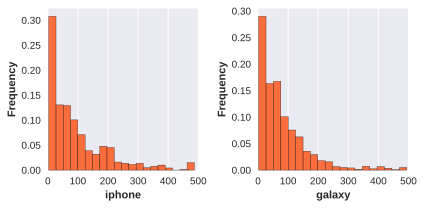

In [40]:
makeHist(df, 'token_count', x_range= (0, 500), bins = 20);

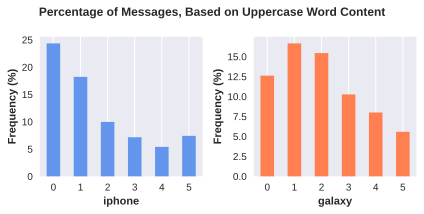

In [41]:
iphoneUpperCase = df.loc[df['is_iphone']=='iphone', 'upper_count'].value_counts(normalize=True)
galaxyUpperCase = df.loc[df['is_iphone']=='galaxy', 'upper_count'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on Uppercase Word Content'
make_multiple_bar_plot(iphoneUpperCase, galaxyUpperCase, max_index=5, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=False)

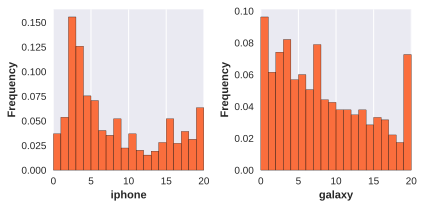

In [40]:
makeHist(df, 'stop_count', x_range= (0, 20), bins = 20);

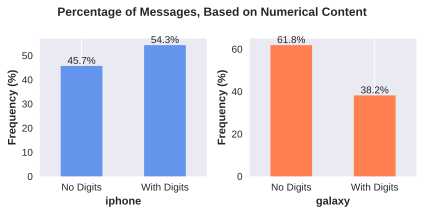

In [42]:
iphoneNumerical = df.loc[df['is_iphone']=='iphone', 'hasNumber'].value_counts(normalize=True)
galaxyNumerical = df.loc[df['is_iphone']=='galaxy', 'hasNumber'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on Numerical Content'
xtick_lbl = ['No Digits', 'With Digits']
make_multiple_bar_plot(iphoneNumerical, galaxyNumerical, max_index=10, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)

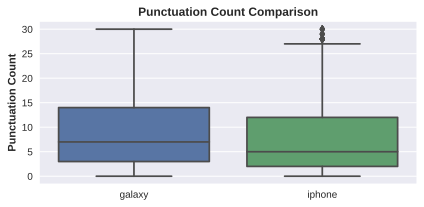

In [42]:
ylbl = 'Punctuation Count'
title = 'Punctuation Count Comparison'
make_box_plot(df, col='is_iphone', refCol='punc_count', x_range=(0, 30), y_label=ylbl, title=title, xRotation=0)

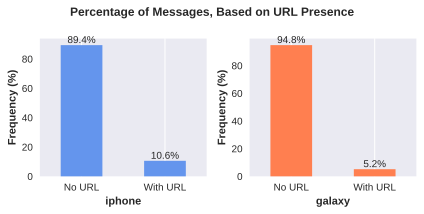

In [43]:
iphoneUrl = df.loc[df['is_iphone']=='iphone', 'hasURL'].value_counts(normalize=True)
galaxyUrl = df.loc[df['is_iphone']=='galaxy', 'hasURL'].value_counts(normalize=True)
if(1 not in iphoneUrl):
    iphoneUrl.loc[1] = 0
if(1 not in galaxyUrl):
    galaxyUrl.loc[1] = 0    
title = 'Percentage of Messages, Based on URL Presence'
xtick_lbl = ['No URL', 'With URL']
make_multiple_bar_plot(iphoneUrl, galaxyUrl, max_index=6, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)

In [44]:
def prepareWordCloud(text, lemmatizerFlag = 1):
    """
    input: 
    text: a text message
    lemmatizerFlag: a flag used for type of text normalization. It is an integer {0, 1}.
                    If 0: stem of word will be used,
                    If 1: lemma of word will be used,
    output: a token list of the message after applying the following steps:
    1- Tokenizing the input text
    2- Removing punctuations and digits 
    3- Transforming into lowercase
    4- Applying stem of word in order to get more hemogenized token list
    """
    # 1- Tokenizing the input text
    tokenLst = nltk.word_tokenize(text)
    
    # 2- Removing punctuations and digits
    tokenLst = [word for word in tokenLst if word.isalpha()]
    
    # 3- Transforming into lowercase
    tokenLst = [word.lower() for word in tokenLst]

    # 4 Removing stopwords
    stopwrodLst = stopwords.words('english')
    tokenLst = [word for word in tokenLst if word not in stopwrodLst]

    # 5 Applying lemma or stem of word in order to get more hemogenized token list
    if(lemmatizerFlag == 0):
        porter = PorterStemmer()
        tokenLst = [porter.stem(word) for word in tokenLst]
    elif(lemmatizerFlag == 1):
        lemmatizer = WordNetLemmatizer()
        tokenLst = [lemmatizer.lemmatize(word) for word in tokenLst]
    return tokenLst

In [45]:
def wordCloudFunc(inputData, isToken = 0, max_words=100, width=1600, height=800, figsize=(15,10), bg_color='k'):
    """
    input:
    inputData: data for making word cloud
    isToken: a flag {0, 1} shows if input is in form of token or not: 0 used for text input, 1 used for token input
    export_file_name: a name used for saving file
    max_words: maximum words for word cloud, default=100,
    width= width of word cloud, default=1600, 
    height= height of word cloud, default=800, 
    figsize=size of return figure, default=(15,10), 
    facecolor=color of word cloud, default='k'
    output: 
    word cloud figure
    """
    if isToken ==1:
        inputData = str(inputData)
    #wordcloud = WordCloud(min_word_length =1,max_words=max_words, width=width, height=height, random_state=1).generate(inputData)
    wordcloud = WordCloud(max_words=max_words, width=width, height=height, background_color=bg_color).generate(inputData)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    
#wordCloudFunc(hamWordLst, isToken = 1, max_words=100, width=1200, height=800, figsize=(8,6), bg_color='black')
#plt.savefig(imageDirectory + '\\img_ham_wcloud.png' , dpi=300, bbox_inches='tight')

In [46]:
df[:2]

,main,date,upvote_ratio,score,num_comments,send_replies,is_video,is_iphone,token,processed_main,hasURL,hasEmail,token_count,avg_word_length,upper_count,stop_count,numeric_count,hasNumber,punc_count
0,Samsung Galaxy Tab S6 Lite Short Review,2021-10-29,1.0,12,5,True,False,galaxy,"[Samsung, Galaxy, Tab, S6, Lite, Short, Review]",Samsung Galaxy Tab S6 Lite Short Review,0,0,7,4.714286,1,0,0,0,0
1,The best I can do with macro on the s22 Ultra....,2022-05-17,1.0,2,1,True,False,galaxy,"[The, best, I, can, do, with, macro, on, the, ...",The best I can do with macro on the s22 Ultra....,0,0,18,3.500000,1,5,0,0,3


In [46]:
df['token_processed'] = df['main'].apply(prepareWordCloud)

# Let's make a word cloud for frequent words
iphoneWordLst = []
galaxyWordLst = []
for tokenLst in df.loc[df['is_iphone'] == 'iphone', 'token_processed'] :
    iphoneWordLst += tokenLst
for tokenLst in df.loc[df['is_iphone'] == 'galaxy', 'token_processed']:
    galaxyWordLst += tokenLst

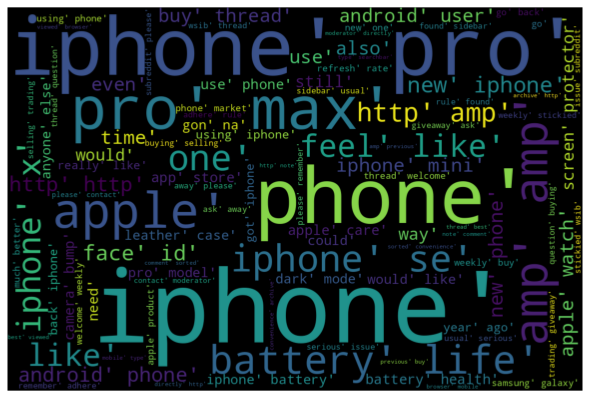

In [47]:
wordCloudFunc(iphoneWordLst, isToken = 1, max_words=100, width=1200, height=800, figsize=(8,6), bg_color='black')

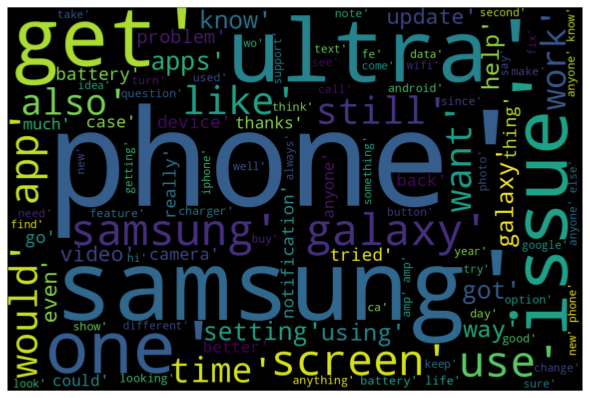

In [48]:
wordCloudFunc(galaxyWordLst, isToken = 1, max_words=100, width=1200, height=800, figsize=(8,6), bg_color='black')

In [49]:
def get_top_n_bigram(input_data, n=10):
    c_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')#.fit(input_data)
    vector_results = c_vectorizer.fit_transform(input_data)
    sum_words = vector_results.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in c_vectorizer.vocabulary_.items()]
    res =sorted(words_freq, key = lambda x: x[1], reverse=True)

    res = res[:n]
    values = [x[1] for x in res]
    indexes = [x[0] for x in res]
    res = pd.Series(values, index=indexes)
    
    #result = pd.Series(words_freq[:n][:,0], index = words_freq[:n][:,1])
    #result = words_freq[:n]
    return res

In [50]:
iphone_data = df.loc[df['is_iphone']=="iphone"]['processed_main']
galaxy_data = df.loc[df['is_iphone']=="galaxy"]['processed_main']

iphone_res = get_top_n_bigram(input_data = iphone_data, n=16)
galaxy_res = get_top_n_bigram(input_data = galaxy_data, n=16)

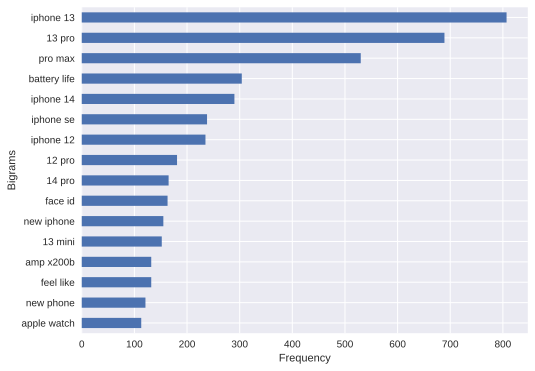

In [51]:
make_bar_plot (iphone_res.sort_values(ascending=True), bartype="barh", xlabel="Frequency", ylabel="Bigrams", size=(8,6))

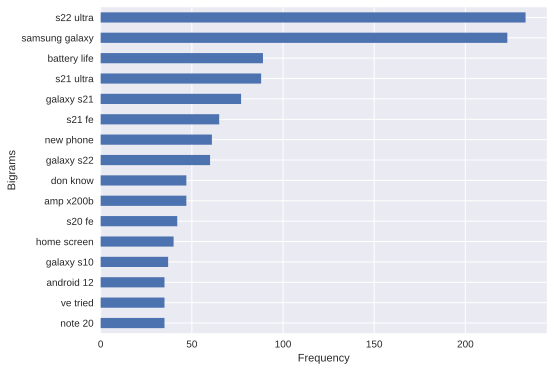

In [52]:
make_bar_plot (galaxy_res.sort_values(ascending=True), bartype="barh", xlabel="Frequency", ylabel="Bigrams", size=(8,6))

## Stanford Core NLP 

In [112]:
import stanza

In [114]:
# We need to run it once:
stanza.download('en')

2022-06-05 21:48:14 INFO: Downloading default packages for language: en (English)...
2022-06-05 21:48:15 INFO: File exists: /home/ted/stanza_resources/en/default.zip
2022-06-05 21:48:18 INFO: Finished downloading models and saved to /home/ted/stanza_resources.


In [115]:
nlp = stanza.Pipeline(lang='en', use_gpu=False, processors='tokenize, sentiment')

2022-06-05 21:48:18 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-06-05 21:48:18 INFO: Use device: cpu
2022-06-05 21:48:18 INFO: Loading: tokenize
2022-06-05 21:48:18 INFO: Loading: sentiment
2022-06-05 21:48:19 INFO: Done loading processors!


## Sentiment Analysis using Stanford CoreNLP model
The SentimentProcessor adds a label for sentiment to each Sentence. 
The existing models each support 
- negative: 0
- neutral: 1
- positive: 2

In [56]:
def convertSentiment(digit):
    if digit == 0:
        return "negative"
    elif digit == 1:
        return "neutral"
    elif digit == 2:
        return "positive"

In [57]:
documents = df["processed_main"].values
in_docs = [stanza.Document([], text=d) for d in documents]
out_docs = nlp(in_docs)
sentiments = [doc.sentences[0].sentiment for doc in out_docs]

In [59]:
sentiments = [doc.sentences[0].sentiment for doc in out_docs]

In [61]:
# Sentiments in form of digits:
df.loc[:, "sentiment_digit"] = sentiments

# Sentiments in form of string:
df.loc[:, "sentiment"] = list(map(convertSentiment, sentiments))

In [62]:
iphoneSentiment = df.loc[df['is_iphone']=='iphone', 'sentiment'].value_counts(normalize=True)
galaxySentiment = df.loc[df['is_iphone']=='galaxy', 'sentiment'].value_counts(normalize=True)

In [63]:
print("Sentiment distribution for Galaxy:")
print(galaxySentiment)
print()
print("****************************************")
print("Sentiment distribution for Iphone:")
print(iphoneSentiment)

Sentiment distribution for Galaxy:
neutral     0.535166
negative    0.385610
positive    0.079224
Name: sentiment, dtype: float64

****************************************
Sentiment distribution for Iphone:
neutral     0.541606
negative    0.360219
positive    0.098175
Name: sentiment, dtype: float64


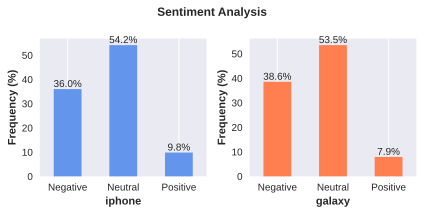

In [64]:
title = 'Sentiment Analysis'
xtick_lbl = ['Negative', 'Neutral', 'Positive']

make_multiple_bar_plot(iphoneSentiment, galaxySentiment, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)

### Insights:
- More than half of the posts are **neutral**.
- Count of **negative** posts are almost 4 times of **positive** posts.
- Distribution of sentiments are pretty similar over the target variable.

In [65]:
# Time range of the records in our dataset:
print(df["date"].min())
print(df["date"].max())

2021-10-08
2022-05-17


### Sentiment aggregation based on time:
- We plan to aggregate records weekly.
- The first task is extracting week number from the date variable
- For that, first we need to convert "date" column into datetime data structure
- Afterward, we will use isocalendar to extract week number
- Since the dataset includes data from year 2021 and 2022, to diffrenciate week number all the weeks of 2022 will be added by 52

In [66]:
df["datetime"] = pd.to_datetime(df['date'])

In [67]:
df['week'] = df['datetime'].dt.isocalendar().week

In [68]:
df.loc[df['datetime'].dt.year == 2022, 'week'] += 52

In [69]:
print(df['week'].min())
print(df['week'].max())

40
72


In [70]:
# Distribution of records based on their week number:
df['week'].value_counts().sort_index()

40      4
42      5
43      9
49      7
52      5
53     15
54     10
57      6
58      5
59      8
60      7
61      8
62    129
63    429
64    497
65    435
66    405
67    347
68    423
69    400
70    320
71    355
72    148
Name: week, dtype: Int64

### Insights:
- Considering the count of records per week shows that statistical analysis would be meaningful after the week 62

In [71]:
# Filtering dataframe just for weeks beyond 62
df_for_grouping = df.loc[df['week']>62]

In [72]:
total_groupby = df_for_grouping.groupby('week')['sentiment'].value_counts(normalize=True)*100
total_groupby

week  sentiment
63    neutral      55.710956
      negative     32.400932
      positive     11.888112
64    neutral      57.142857
      negative     36.619718
      positive      6.237425
65    neutral      50.344828
      negative     42.528736
      positive      7.126437
66    neutral      56.296296
      negative     31.851852
      positive     11.851852
67    neutral      48.991354
      negative     41.210375
      positive      9.798271
68    neutral      45.626478
      negative     41.607565
      positive     12.765957
69    neutral      56.250000
      negative     32.250000
      positive     11.500000
70    neutral      59.375000
      negative     32.500000
      positive      8.125000
71    neutral      52.394366
      negative     45.070423
      positive      2.535211
72    neutral      70.945946
      negative     28.378378
      positive      0.675676
Name: sentiment, dtype: float64

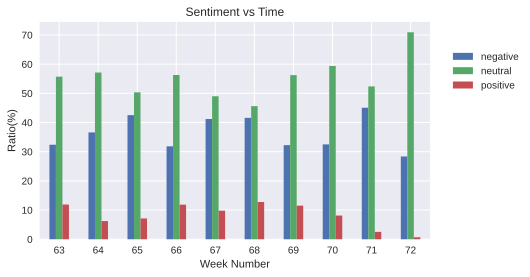

In [73]:
#total_groupby.unstack().plot(kind = "bar")

make_bar_plot(total_groupby.unstack(), title="Sentiment vs Time" ,xlabel="Week Number", ylabel="Ratio(%)", size=(7,4), legend=True)

### Insights:
- General trends of sentiment distribution is: Neutral>Negative>Positive
- Positive sentiment distribution:
    - Minimum positive ratio belongs to weeks 71 and 72
    - Maximum positive ratio belongs to weeks 63, 66, 68, and 69
- Negative sentiment distribution:
    - Minimum negative ratio belongs to weeks 63, 66, 69, 70
    - Maximum positive ratio belongs to weeks 65, 70


### Sentiment for Iphone posts:

In [74]:
iphone_groupby_sentiment= df_for_grouping.loc[df_for_grouping['is_iphone']=='iphone'].groupby('week')['sentiment'].value_counts(normalize=True)
iphone_groupby_sentiment.index.values

array([(63, 'neutral'), (63, 'negative'), (63, 'positive'),
       (64, 'neutral'), (64, 'negative'), (64, 'positive'),
       (65, 'neutral'), (65, 'negative'), (65, 'positive'),
       (66, 'neutral'), (66, 'negative'), (66, 'positive'),
       (67, 'neutral'), (67, 'negative'), (67, 'positive'),
       (68, 'negative'), (68, 'neutral'), (68, 'positive'),
       (69, 'neutral'), (69, 'negative'), (69, 'positive'),
       (70, 'neutral'), (70, 'negative'), (70, 'positive'),
       (71, 'negative'), (71, 'neutral'), (71, 'positive'),
       (72, 'neutral'), (72, 'negative')], dtype=object)

In [75]:
iphone_groupby_negative = iphone_groupby_sentiment.loc[:, 'negative']
iphone_groupby_positive = iphone_groupby_sentiment.loc[:, 'positive']
iphone_groupby_negative

week
63    0.319149
64    0.379009
65    0.408163
66    0.264368
67    0.384236
68    0.444444
69    0.291139
70    0.312500
71    0.530233
72    0.228814
Name: sentiment, dtype: float64

### Sentiment for Galaxy posts:

In [76]:
galaxy_groupby_sentiment= df_for_grouping.loc[df_for_grouping['is_iphone']=='galaxy'].groupby('week')['sentiment'].value_counts(normalize=True)
galaxy_groupby_sentiment.index.values

array([(63, 'negative'), (63, 'neutral'), (63, 'positive'),
       (64, 'neutral'), (64, 'negative'), (64, 'positive'),
       (65, 'negative'), (65, 'neutral'), (65, 'positive'),
       (66, 'neutral'), (66, 'negative'), (66, 'positive'),
       (67, 'neutral'), (67, 'negative'), (67, 'positive'),
       (68, 'neutral'), (68, 'negative'), (68, 'positive'),
       (69, 'neutral'), (69, 'negative'), (69, 'positive'),
       (70, 'neutral'), (70, 'negative'), (70, 'positive'),
       (71, 'neutral'), (71, 'negative'), (71, 'positive'),
       (72, 'negative'), (72, 'neutral'), (72, 'positive')], dtype=object)

In [77]:
galaxy_groupby_negative = galaxy_groupby_sentiment.loc[:, 'negative']
galaxy_groupby_positive = galaxy_groupby_sentiment.loc[:, 'positive']
galaxy_groupby_negative

week
63    0.666667
64    0.337662
65    0.460993
66    0.416667
67    0.451389
68    0.366013
69    0.368098
70    0.337500
71    0.328571
72    0.500000
Name: sentiment, dtype: float64

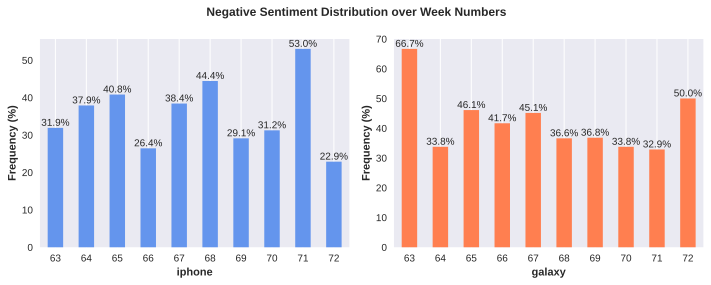

In [78]:
#make_bar_plot(iphone_groupby_negative, title="Sentiment vs Time" ,xlabel="Week Number", ylabel="Ratio(%)", size=(7,4))

title = "Negative Sentiment Distribution over Week Numbers"
make_multiple_bar_plot(iphone_groupby_negative, galaxy_groupby_negative, y_label=None, figTitle=title, xRotation=0, figsize=(10, 4))

### Insights:
- The maximum % of negative sentiment for Galaxy is higher that Iphone (week 63)
- An increasing trend of negative sentiment for Iphone has been detected. According to our dataset, this trend is repeated each three weeks.
- In contrast, galaxy does not show a meaningful trend for the negative sentiment.

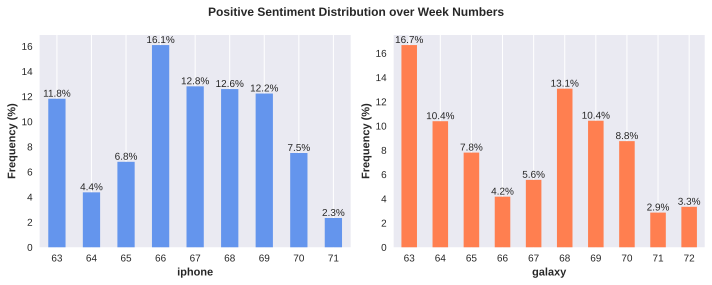

In [79]:
title = "Positive Sentiment Distribution over Week Numbers"
make_multiple_bar_plot(iphone_groupby_positive, galaxy_groupby_positive, y_label=None, figTitle=title, xRotation=0, figsize=(10, 4))

### Insights:
- For iphone, the maximum positive sentiment are acheived continously in weeks 66, 67, 68, 69
- In contrast, for galaxy, the maximum positive sentiment are not continously, in weeks 63 and 68

## Named Entity Recognition (NER) analysis using Stanford CoreNLP model


In [166]:
stanza_model = stanza.Pipeline(use_gpu=False, lang='en', processors='tokenize, ner')


2022-06-04 01:42:36 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-06-04 01:42:36 INFO: Use device: cpu
2022-06-04 01:42:36 INFO: Loading: tokenize
2022-06-04 01:42:36 INFO: Loading: ner
2022-06-04 01:42:36 INFO: Done loading processors!


In [119]:
# Input text preparation
iphone_input_text_lst = df.loc[df['is_iphone']=='iphone', 'processed_main'].values
galaxy_input_text_lst = df.loc[df['is_iphone']=='galaxy', 'processed_main'].values

### NER For Iphone

In [192]:
in_docs = [stanza.Document([], text=d) for d in iphone_input_text_lst]
stanza_res = stanza_model(in_docs)
stanza_res

iphone_ner = []
for doc in in_docs:
    for sent in doc.sentences:
        for ent in sent.ents:
            iphone_ner.append((ent.text, ent.type))

### NER For Galaxy

In [195]:
in_docs = [stanza.Document([], text=d) for d in galaxy_input_text_lst]
stanza_res = stanza_model(in_docs)
stanza_res

galaxy_ner = []
for doc in in_docs:
    for sent in doc.sentences:
        for ent in sent.ents:
            galaxy_ner.append((ent.text, ent.type))

In [197]:
uniq_ner = []
for x in galaxy_ner:
    if x[1] not in uniq_ner:
        uniq_ner.append(x[1])
print(uniq_ner)

['ORG', 'CARDINAL', 'TIME', 'DATE', 'WORK_OF_ART', 'PRODUCT', 'PERCENT', 'QUANTITY', 'GPE', 'ORDINAL', 'NORP', 'PERSON', 'MONEY', 'EVENT', 'FAC', 'LOC', 'LANGUAGE', 'LAW']


In [198]:
filtered_ner = ["ORG", "FAC", "GPE", "LOC", "PERSON"]

### Filtering Iphone Entities

In [202]:
selected_iphone_ner = []
for x in iphone_ner:
    if x[1] in ["ORG", "FAC"]:
        selected_iphone_ner.append((x[0], "ORG"))
    elif x[1] in ["GPE", "LOC"]:
        selected_iphone_ner.append((x[0], "LOC"))
    elif x[1]=="PERSON":
        selected_iphone_ner.append(x)

### Filtering Galaxy Entities

In [201]:
selected_galaxy_ner = []
for x in galaxy_ner:
    if x[1] in ["ORG", "FAC"]:
        selected_galaxy_ner.append((x[0], "ORG"))
    elif x[1] in ["GPE", "LOC"]:
        selected_galaxy_ner.append((x[0], "LOC"))
    elif x[1]=="PERSON":
        selected_galaxy_ner.append(x)

In [203]:
print(len(selected_iphone_ner))
print(len(selected_galaxy_ner))

4691
1370


In [204]:
selected_iphone_ner[:4]

[('WSIB', 'ORG'),
 ('r/iPhoneHelp Original', 'ORG'),
 ('Service Dogs', 'ORG'),
 ('Abby', 'PERSON')]

In [129]:
from collections import Counter

In [210]:
top_org_iphone = Counter([x for x in selected_iphone_ner if x[1]=="ORG"]).most_common(25)
top_loc_iphone = Counter([x for x in selected_iphone_ner if x[1]=="LOC"]).most_common(25)
top_person_iphone = Counter([x for x in selected_iphone_ner if x[1]=="PERSON"]).most_common(25)

In [220]:
def make_serries(input_lst):
    
    keys = [x[0][0] for x in input_lst]
    values = [x[1] for x in input_lst]
        
    ser = pd.Series(values, index = keys)
    return ser

In [221]:
iphone_org_serries = make_serries(top_org_iphone)
iphone_loc_serries = make_serries(top_loc_iphone)
iphone_person_serries = make_serries(top_person_iphone)

In [225]:
iphone_org_serries

Apple            1300
Samsung           280
Android           106
Google             94
iOS                69
WSIB               58
Verizon            45
Pro Max            36
Wikipedia          36
Apple Watch        35
YouTube            33
Facebook           32
SE                 30
Apple Pay          30
the App Store      29
eBay               26
Reddit             26
EU                 25
the 13 Pro         23
WhatsApp           22
Twitter            22
CarPlay            21
Google Maps        21
Heart Tempo        21
MagSafe            19
dtype: int64

In [226]:
org_tobe_deleted = ["iOS", "Pro Max", "Apple Watch", "SE", "Apple Pay", "the 13 Pro"]
iphone_org_serries.drop(org_tobe_deleted, inplace=True)

In [228]:
iphone_loc_serries

US               68
India            35
Australia        28
Colombia         24
Bogota           16
Europe           12
Philippines      12
Canada           10
Brazil            9
Indianapolis      9
Arizona           8
Caracol           8
CarPlay           7
Shanghai          7
Covid             7
Shenzhen          7
West              7
Metro Cebu        6
Leyte             6
Cebu              6
NYC               6
Ukraine           6
New Orleans       6
Moscow            6
North America     5
dtype: int64

In [229]:
loc_tobe_deleted = ["CarPlay", "Covid"]
iphone_loc_serries.drop(loc_tobe_deleted, inplace=True)

In [230]:
top_org_galaxy = Counter([x for x in selected_galaxy_ner if x[1]=="ORG"]).most_common(25)
top_loc_galaxy = Counter([x for x in selected_galaxy_ner if x[1]=="LOC"]).most_common(25)
top_person_galaxy = Counter([x for x in selected_galaxy_ner if x[1]=="PERSON"]).most_common(25)

In [231]:
galaxy_org_serries = make_serries(top_org_galaxy)
galaxy_loc_serries = make_serries(top_loc_galaxy)
galaxy_person_serries = make_serries(top_person_galaxy)

In [232]:
galaxy_org_serries

Samsung           410
Google             60
Samsung Galaxy     45
Amazon             33
Spotify            28
YouTube            25
S22 Ultra          25
S22                20
Verizon            15
Galaxy             14
FE                 13
Instagram          12
RCS                12
Snapdragon         12
Exynos             11
Apple              10
Samsung Music       9
QR                  8
WhatsApp            7
Netflix             7
YouTube Music       7
UI                  6
2FA                 6
S21 Ultra           6
ATT                 6
dtype: int64

In [233]:
org_tobe_deleted = ["S22 Ultra", "S22", "Samsung Music", "S21 Ultra", "2FA", "QR"]
galaxy_org_serries.drop(org_tobe_deleted, inplace=True)

In [237]:
galaxy_loc_serries[:15]

US                   15
UK                   10
India                 6
Texas                 3
NC                    3
USA                   3
Republic              3
Japan                 2
Mexico                2
UAE                   2
Canada                2
Panama                1
Ultra                 1
Denmark               1
a Pacific Country     1
dtype: int64

In [240]:
galaxy_loc_serries = galaxy_loc_serries[:15]
loc_tobe_deleted = ["Republic", "Ultra", "a Pacific Country"]
galaxy_loc_serries.drop(loc_tobe_deleted, inplace=True)

### NER visualization

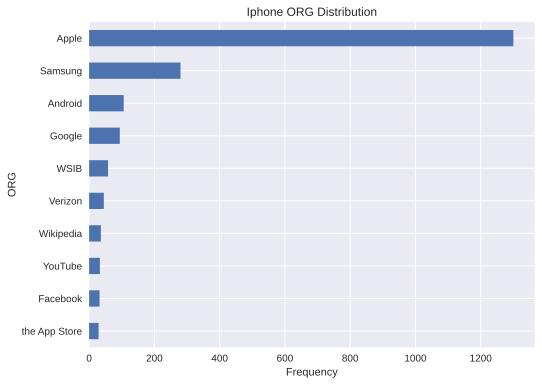

In [254]:
make_bar_plot(iphone_org_serries[:10].sort_values(ascending=True), bartype="barh", title="Iphone ORG Distribution", xlabel="Frequency", ylabel="ORG", size=(8,6))

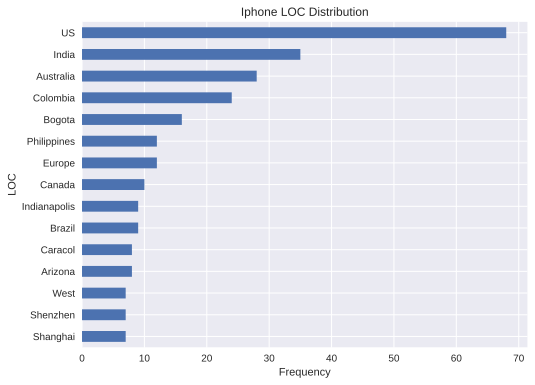

In [256]:
make_bar_plot(iphone_loc_serries[:15].sort_values(ascending=True), bartype="barh", title="Iphone LOC Distribution", xlabel="Frequency", ylabel="LOC", size=(8,6))

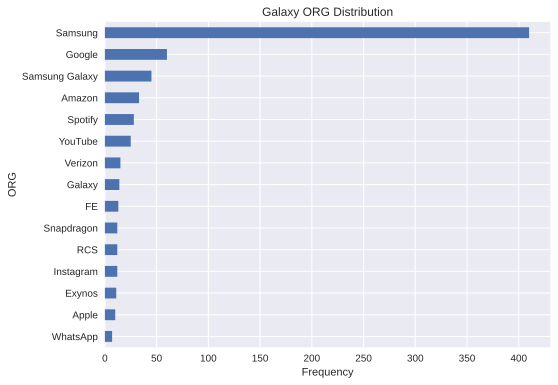

In [255]:
make_bar_plot(galaxy_org_serries[:15].sort_values(ascending=True), bartype="barh", title="Galaxy ORG Distribution", xlabel="Frequency", ylabel="ORG", size=(8,6))

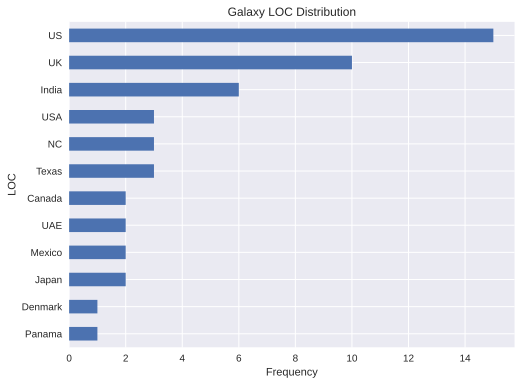

In [257]:
make_bar_plot(galaxy_loc_serries[:15].sort_values(ascending=True), bartype="barh", title="Galaxy LOC Distribution", xlabel="Frequency", ylabel="LOC", size=(8,6))

# Part of Speech (POS) Analysis

In [117]:
pos_analyzer = stanza.Pipeline(lang='en', use_gpu=False, processors='tokenize,mwt,pos')

2022-06-05 21:49:51 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-05 21:49:51 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-06-05 21:49:51 INFO: Use device: cpu
2022-06-05 21:49:51 INFO: Loading: tokenize
2022-06-05 21:49:51 INFO: Loading: pos
2022-06-05 21:49:52 INFO: Done loading processors!


In [123]:
pos_reference = ["PROPN", "VERB", "ADJ", "NOUN"]

In [125]:
in_docs = [stanza.Document([], text=d) for d in iphone_input_text_lst]
pos_res = pos_analyzer(in_docs)

iphone_pos = []
for doc in in_docs:
    for sent in doc.sentences:
        for word in sent.words:
            if word.upos in pos_reference:
                pos_extracted = (word.text, word.upos)
                iphone_pos.append(pos_extracted)

In [126]:
in_docs = [stanza.Document([], text=d) for d in galaxy_input_text_lst]
pos_res = pos_analyzer(in_docs)

galaxy_pos = []
for doc in in_docs:
    for sent in doc.sentences:
        for word in sent.words:
            if word.upos in pos_reference:
                pos_extracted = (word.text, word.upos)
                galaxy_pos.append(pos_extracted)

In [127]:
iphone_pos[:10]

[('Weekly', 'ADJ'),
 ('Buy', 'VERB'),
 ('Thread', 'PROPN'),
 ('Welcome', 'PROPN'),
 ('weekly', 'ADJ'),
 ('stickied', 'VERB'),
 ('WSIB', 'NOUN'),
 ('thread', 'NOUN'),
 ('Have', 'VERB'),
 ('questions', 'NOUN')]

In [152]:
top_propn_iphone = Counter([x for x in iphone_pos if x[1]=="PROPN"]).most_common(15)
top_verb_iphone = Counter([x for x in iphone_pos if x[1]=="VERB"]).most_common(15)
top_adj_iphone = Counter([x for x in iphone_pos if x[1]=="ADJ"]).most_common(15)
top_noun_iphone = Counter([x for x in iphone_pos if x[1]=="NOUN"]).most_common(15)

top_propn_galaxy = Counter([x for x in galaxy_pos if x[1]=="PROPN"]).most_common(15)
top_verb_galaxy = Counter([x for x in galaxy_pos if x[1]=="VERB"]).most_common(15)
top_adj_galaxy = Counter([x for x in galaxy_pos if x[1]=="ADJ"]).most_common(15)
top_noun_galaxy = Counter([x for x in galaxy_pos if x[1]=="NOUN"]).most_common(15)

In [153]:
top_verb_galaxy[:5]

[(('have', 'VERB'), 564),
 (('get', 'VERB'), 304),
 (('know', 'VERB'), 232),
 (('use', 'VERB'), 203),
 (('had', 'VERB'), 188)]

In [154]:
top_propn_iphone = [x[0][0] for x in top_propn_iphone]
top_verb_iphone = [x[0][0] for x in top_verb_iphone]
top_adj_iphone = [x[0][0] for x in top_adj_iphone]
top_noun_iphone = [x[0][0] for x in top_noun_iphone]

top_propn_galaxy = [x[0][0] for x in top_propn_galaxy]
top_verb_galaxy = [x[0][0] for x in top_verb_galaxy]
top_adj_galaxy = [x[0][0] for x in top_adj_galaxy]
top_noun_galaxy = [x[0][0] for x in top_noun_galaxy]

In [155]:
top_propn_iphone

['iPhone',
 'Apple',
 'Pro',
 'iOS',
 'Android',
 'Max',
 'iPhones',
 'SE',
 'Samsung',
 'url_plh',
 'iPad',
 'android',
 'Google',
 'Siri',
 ';#x200B']

In [156]:
top_propn_galaxy

['Samsung',
 'Galaxy',
 'S22',
 'Ultra',
 'S21',
 'FE',
 'S20',
 'Google',
 'Android',
 'iPhone',
 'url_plh',
 'S10',
 'galaxy',
 ';#x200B',
 'A53']

In [157]:
unique_iphone_propn = [x for x in top_propn_iphone if x not in top_propn_galaxy]
unique_iphone_verb = [x for x in top_verb_iphone if x not in top_verb_galaxy]
unique_iphone_adj = [x for x in top_adj_iphone if x not in top_adj_galaxy]
unique_iphone_noun = [x for x in top_noun_iphone if x not in top_noun_galaxy]

unique_galaxy_propn = [x for x in top_propn_galaxy if x not in top_propn_iphone]
unique_galaxy_verb = [x for x in top_verb_galaxy if x not in top_verb_iphone]
unique_galaxy_adj = [x for x in top_adj_galaxy if x not in top_adj_iphone]
unique_galaxy_noun = [x for x in top_noun_galaxy if x not in top_noun_iphone]

## Proper noun comparison:

In [158]:
unique_iphone_propn

['Apple', 'Pro', 'iOS', 'Max', 'iPhones', 'SE', 'iPad', 'android', 'Siri']

In [159]:
unique_galaxy_propn

['Galaxy', 'S22', 'Ultra', 'S21', 'FE', 'S20', 'S10', 'galaxy', 'A53']

### Insights:
- As it was expected, the unique proper noun are strongly brand dependent.
- Most of the galaxy high frequency words are about Galaxy S serries. The only non-S serries is A53
- For Apple, except for different models, Siri is also a very frequent proper noun.

## Verb comparison:

In [160]:
unique_iphone_verb

['think', 'make', 'like', 'see']

In [161]:
unique_galaxy_verb

['do', 'tried', 'find', 'used']

### Insights:
- Galaxy unique collection verbs are more about action-related verbs like do, try, use, find
- In contrast, for iphone are more about perception-related verbs like: like, see, think

## Adjective comparison:

In [162]:
unique_iphone_adj

['great', 'first', 'best', 'many', 'little', 'big']

In [163]:
unique_galaxy_adj

['different', 'sure', 'else', 'bad', 'able', 'much']

### Insights:
- more positive adjectives for iphone: great, best, first
- none positive adjectives for galaxy: bad, else, different

## Noun comparison:

In [164]:
unique_iphone_noun

['people', 'case', 'years', 'apple', 'one']

In [165]:
unique_galaxy_noun

['issue', 'update', 'settings', 'Thanks', 'device']

### Insights:
- For iphone, users talk more about general subjects like: case, years, people
- For galaxy, user talk more about software-associate words like: update, settings

# Subjectivity Analysis:

- We are using textblob library for getting the subjectivity level.
- According to textblob documents, Subjectivity lies between [0.0,1.0]:
- 0.0 is very objective
- 1.0 is very subjective
- 0.5 can be a kind of threshold, indeed, if subjectivity < 0.5, the sentence is more subjective than objective and vice versa.

In [83]:
# Installing textblob: 
# !pip install -U textblob

In [99]:
def find_subjectivity_level(text):
    """
    This function will apply textblob on a given text:
    The result of textblob would be like:
    --> Sentiment(polarity=0.0, subjectivity=0.0)
    In order to extract the subjectivity, we just need to extract the second value
    """
    
    result = TextBlob(text)
    #sentiment_value = result.sentiment[0]
    subjectivity_value = result.sentiment[1]
    
    return subjectivity_value

In [100]:
df['subjectivity'] = df['processed_main'].apply(find_subjectivity_level)

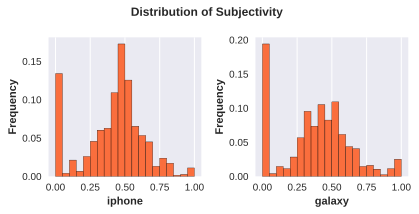

In [102]:
makeHist(df, col="subjectivity", bins=20,title="Distribution of Subjectivity")

### Insights:
- In both classes, subjectivity of zero has considerable frequency, followed by a semi-normal distribution with a mode of 0.5
- The behaivior of subjectivity over the two classes are very similar. So, it is not a great candidate as a feature for prediction modeling.

### Some examples with low subjectivity level:

In [107]:
low_sub_samples = df.loc[df['subjectivity']==0, "processed_main"][:5].values
for x in low_sub_samples:
    print(x)
    print("****************************************************************************")

Lunar Eclipse progression as captured in Texas with my s22 Ultra 
****************************************************************************
Can't wait to unbox this! 
****************************************************************************
There used to be a bird here. How do I undo the AI processing on photos? [S22 Ultra] 
****************************************************************************
My Tab A (2018, 10.5) Fell on floor and this happened... 
****************************************************************************
Samsung Galaxy A53 vs M53 - Comparison - Choose Your Mobile 
****************************************************************************


### Some examples with high subjectivity level:

In [108]:
high_sub_samples = df.loc[df['subjectivity']>0.85, "processed_main"][:5].values
for x in high_sub_samples:
    print(x)
    print("*****************************************************************")

Samsung Galaxy A32 One UI 4.1 (Android 12) update nothing impressive 
*****************************************************************
S22 keeps turning off WiFi in settings; costing me data! Anybody notice when you go in settings that their WiFi is 'off'; I never turn it off.  I never heard of a service provider turning off wifi on your phone to ring the register, probably because it's not possible.
*****************************************************************
[A 72] Edge Panels don't work well with the latest update from Galaxy Store 
*****************************************************************
base Galaxy S22 30x zoom to the moon 
*****************************************************************
S22U Ridiculous zoom (Table Rock, NC) 
*****************************************************************


In [168]:
df[:2]

,main,date,upvote_ratio,score,num_comments,send_replies,is_video,is_iphone,token,processed_main,...,stop_count,numeric_count,hasNumber,punc_count,token_processed,sentiment_digit,sentiment,datetime,week,subjectivity
0,Samsung Galaxy Tab S6 Lite Short Review,2021-10-29,1.0,12,5,True,False,galaxy,"[Samsung, Galaxy, Tab, S6, Lite, Short, Review]",Samsung Galaxy Tab S6 Lite Short Review,...,0,0,0,0,"[samsung, galaxy, tab, lite, short, review]",1,neutral,2021-10-29,43,0.300000
1,The best I can do with macro on the s22 Ultra....,2022-05-17,1.0,2,1,True,False,galaxy,"[The, best, I, can, do, with, macro, on, the, ...",The best I can do with macro on the s22 Ultra....,...,5,0,0,3,"[best, macro, ultra, super, impressed, honestly]",1,neutral,2022-05-17,72,0.716667


In [179]:
dropped_cols = ["main", "date", "token", "token_processed", "sentiment", "datetime"]
final_df = df.drop(dropped_cols, axis=1)

In [183]:
final_df['is_video'] = final_df['is_video'].map({True: 1, False: 0})
final_df['send_replies'] = final_df['send_replies'].map({True: 1, False: 0})

In [184]:
dataDirectory = "./data/"
final_df.to_csv(dataDirectory + "df_for_model.csv", encoding='utf-8')
df.to_csv(dataDirectory + "comprehensive_df.csv", encoding='utf-8')